## First Section

### 1. Library imports

In [2]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils import plot_model
from pickle import load, dump
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import warnings
warnings.filterwarnings("ignore")


### 2. Data Loading and Preprocessing

In [12]:
# Update this path to the location of your updated dataset
dataset_path = 'stock_tweets_with_sentiment.csv'

# Load the dataset
all_tweets = pd.read_csv(dataset_path)

# Selecting a specific stock - for example, 'AMZN'
stock_name = 'AMZN'
df = all_tweets[all_tweets['Stock Name'] == stock_name]

# Display the shape and first few rows of the dataset
print(df.shape)
df.head()


(4089, 7)


,Date,Tweet,Stock Name,Company Name,cleaned_tweet,Tweet Length,compound_score
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",group lawmaker led sen elizabeth warren dmass...,195,-0.0772
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",nio m money nt mean bad investment whole mar...,212,0.2500
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",today drop spx perfect example happens aapl...,274,-0.3182
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",druckenmiller owned cvna year munger bought ...,280,0.2382
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",top 10 qqq holding credit rating aapl aaa ...,233,0.7783


In [41]:
sent_df = df.copy()
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,cleaned_tweet,Tweet Length,compound_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",group lawmaker led sen elizabeth warren dmass...,195,-0.0772,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",nio m money nt mean bad investment whole mar...,212,0.2500,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",today drop spx perfect example happens aapl...,274,-0.3182,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",druckenmiller owned cvna year munger bought ...,280,0.2382,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",top 10 qqq holding credit rating aapl aaa ...,233,0.7783,,,


In [42]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sentiment_analyzer = SentimentIntensityAnalyzer()

for indx, row in sent_df.iterrows():
    try:
        # Normalize the text
        sentence = unicodedata.normalize('NFKD', row['Tweet'])
        
        # Get sentiment scores
        sentiment_scores = sentiment_analyzer.polarity_scores(sentence)

        # Store the scores in the DataFrame
        sent_df.at[indx, 'Negative'] = sentiment_scores['neg']
        sent_df.at[indx, 'Neutral'] = sentiment_scores['neu']
        sent_df.at[indx, 'Positive'] = sentiment_scores['pos']
    except TypeError as e:
        print(f"Error processing row index {indx}: {e}")


In [43]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,cleaned_tweet,Tweet Length,compound_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",group lawmaker led sen elizabeth warren dmass...,195,-0.0772,0.084,0.841,0.075
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",nio m money nt mean bad investment whole mar...,212,0.2500,0.158,0.684,0.158
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",today drop spx perfect example happens aapl...,274,-0.3182,0.164,0.728,0.108
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",druckenmiller owned cvna year munger bought ...,280,0.2382,0.065,0.851,0.083
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",top 10 qqq holding credit rating aapl aaa ...,233,0.7783,0.0,0.799,0.201


In [55]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df_1  = sent_df.drop(columns = ['Tweet','Tweet Length','Negative', 'Neutral', 'Positive','Stock Name', 'Company Name'])

In [56]:
sent_df_1.head()

,Date,cleaned_tweet,compound_score
48351,2022-09-29,group lawmaker led sen elizabeth warren dmass...,-0.0772
48352,2022-09-29,nio m money nt mean bad investment whole mar...,0.2500
48353,2022-09-29,today drop spx perfect example happens aapl...,-0.3182
48354,2022-09-29,druckenmiller owned cvna year munger bought ...,0.2382
48355,2022-09-29,top 10 qqq holding credit rating aapl aaa ...,0.7783


In [57]:
# Select only the numeric columns for mean calculation
numeric_cols = sent_df_1.select_dtypes(include=[np.number])

# Group by 'Date' and calculate mean only for the numeric columns
twitter_df = numeric_cols.groupby(sent_df_1['Date']).mean().reset_index()
print(twitter_df.shape)


(365, 2)


In [58]:
twitter_df.head()

,Date,compound_score
0,2021-09-30,0.246480
1,2021-10-01,0.359337
2,2021-10-02,-0.000700
3,2021-10-03,0.834400
4,2021-10-04,0.258650


## Get final dataset for training

In [59]:
# Load the stock price data
stock_price_path = 'stock_yfinance_data.csv'
stock_prices_df = pd.read_csv(stock_price_path)

print(stock_prices_df.shape)
stock_prices_df.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [60]:
stock_df = stock_prices_df[stock_prices_df['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [66]:
final_df = pd.merge(twitter_df, stock_df, on='Date', how='inner')
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [67]:
final_df.head()

,Date,compound_score,Open,High,Low,Close,Adj Close,Volume
0,2021-09-30,0.246480,165.800003,166.392502,163.699493,164.251999,164.251999,56848000
1,2021-10-01,0.359337,164.450500,165.458496,162.796997,164.162994,164.162994,56712000
2,2021-10-04,0.258650,163.969498,163.999496,158.812500,159.488998,159.488998,90462000
3,2021-10-05,0.045500,160.225006,163.036499,160.123001,161.050003,161.050003,65384000
4,2021-10-06,0.194300,160.676498,163.216995,159.931000,163.100494,163.100494,50660000


Let's plot historical price data for the analyzed price data stock ticker : 

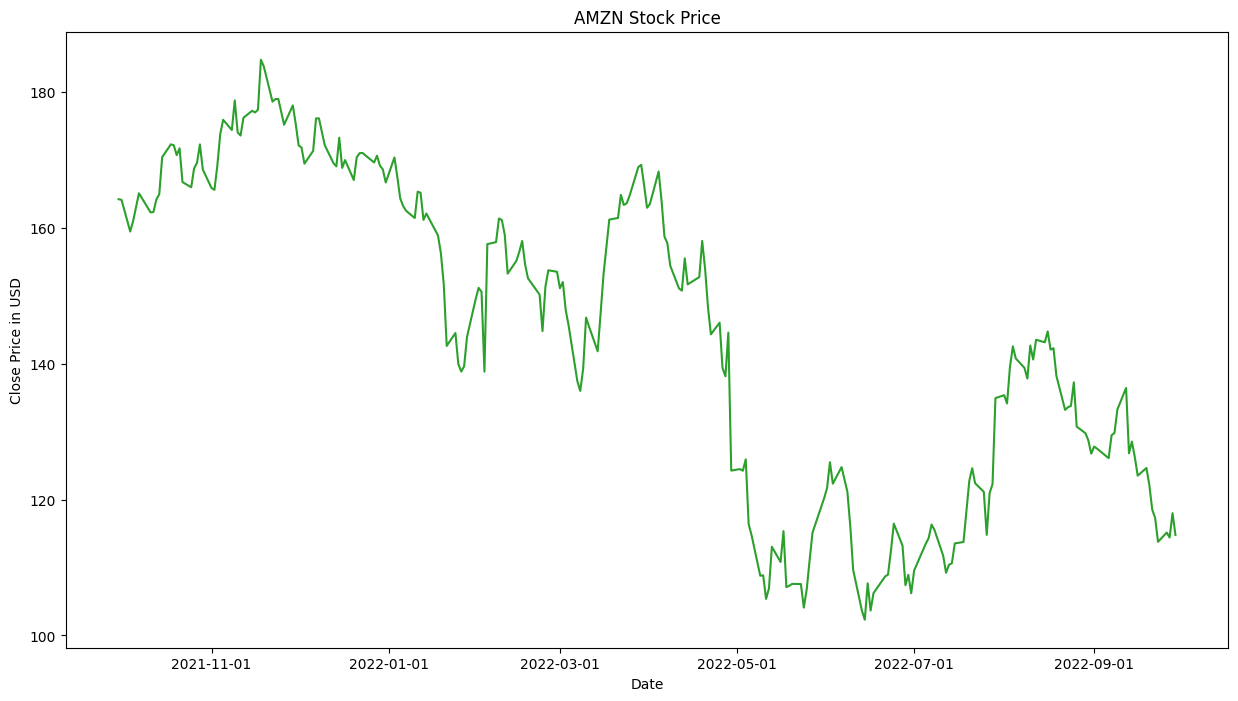

In [69]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#2CA02C')
ax.set(xlabel="Date", ylabel="Close Price in USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.show()

* Adding technical indicators

We're using : 

* **MA(7)**
* **MA(20)**
* **EMA**
* **Bollinger Bands**

In [71]:
def get_tech_indicators(data):
    data['MA7'] = data['Close'].rolling(window=7).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    
    data['26ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['12ema'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['MACD'] = data['12ema'] - data['26ema']
    data.drop(['26ema','12ema'],axis=1,inplace=True)
    
    #Create Bollinger Bands
    data['20sd'] = data['Close'].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20sd']*2)
    data['lower_band'] = data['MA20'] - (data['20sd']*2)

    #Create Exponential moving average
    data['ema'] = data['Close'].ewm(com=0.5).mean()

    #Create LogMomentum
    data['logmomentum'] = np.log(data['Close']-1)

    return data

In [72]:
tech_df = get_tech_indicators(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,compound_score,Open,High,Low,Close,Adj Close,Volume,MA7,MA20,MACD,20sd,upper_band,lower_band,ema,logmomentum
0,2021-10-28,-0.001450,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,169.436571,166.614751,1.639031,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,0.140447,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,169.132071,166.837676,1.509062,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,0.369745,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,168.297071,167.158501,1.173376,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,0.336614,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,168.134214,167.387876,0.875623,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,0.260729,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,168.588715,167.692851,0.916550,3.324309,174.341469,161.044234,168.175464,5.125154


In [75]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15,8), dpi = 200)
    x_ = range(3,dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average 7 Days', color='g',linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'],label='Closing Price', color='b')
    ax.plot(dataset['Date'], dataset['MA20'],label='Moving Average (20 days)', color='r',linestyle='--')
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.title('Techincal Indicators')
    plt.ylabel('Close Price in USD')
    plt.xlabel('Date')
    plt.legend()

    plt.show()

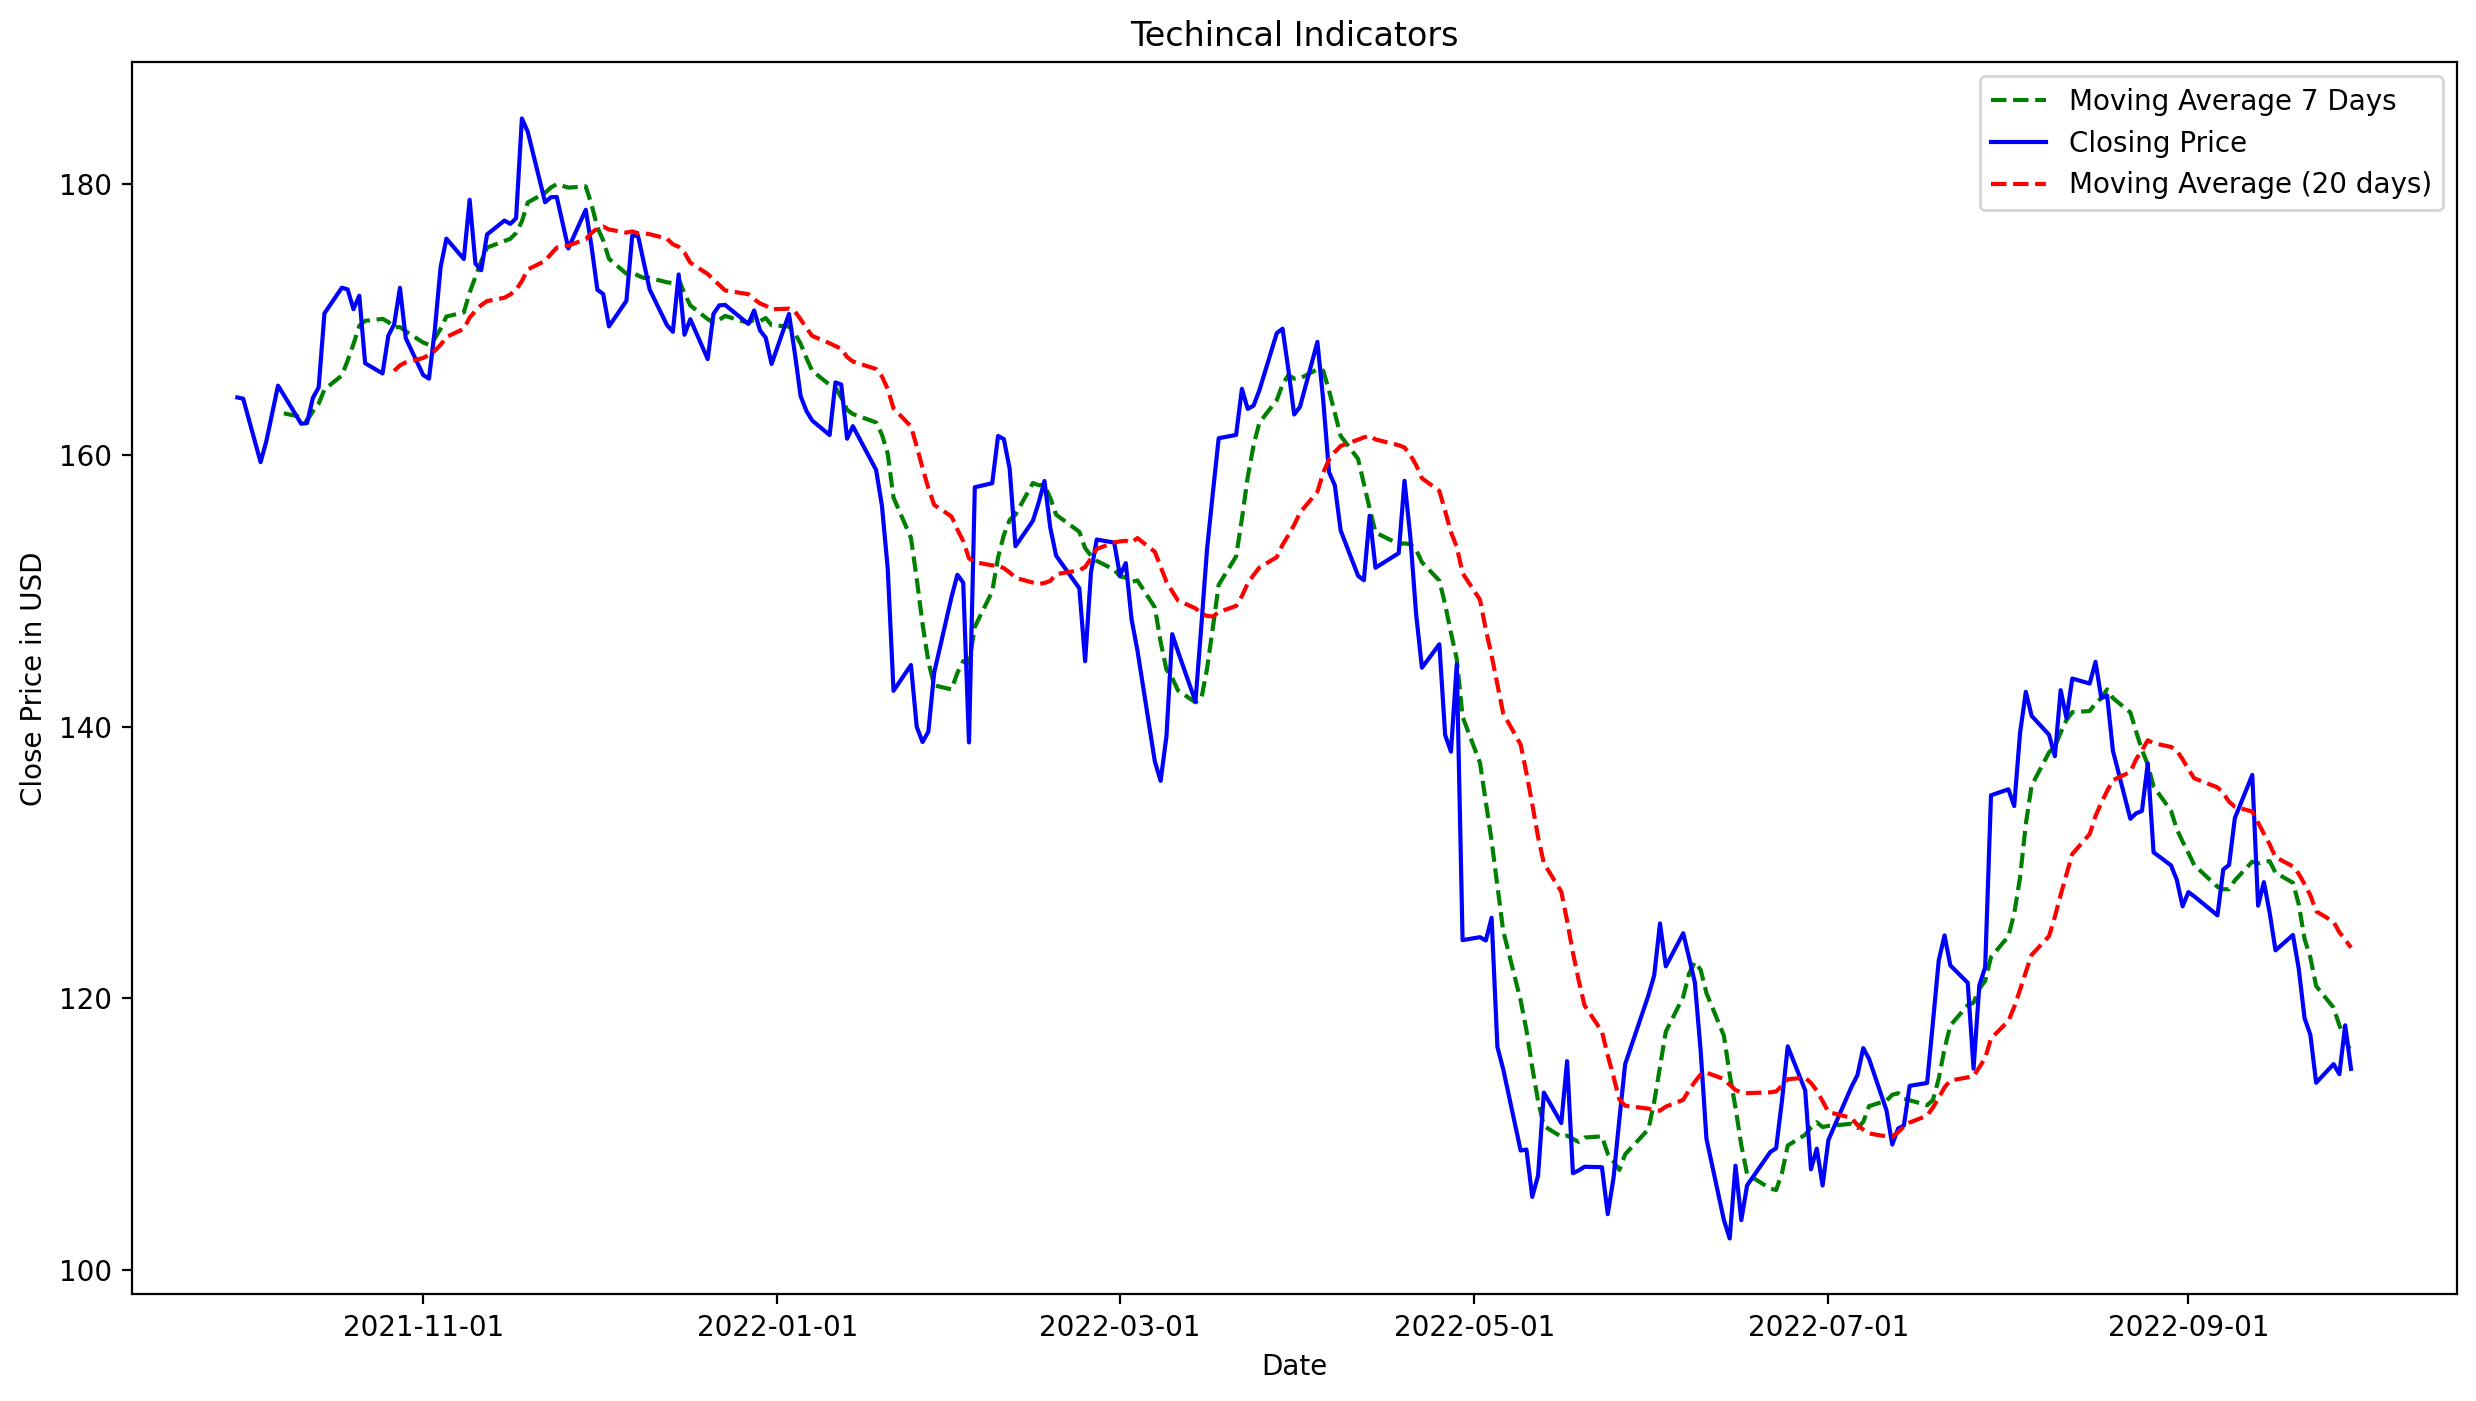

In [76]:
tech_ind(tech_df)

In [77]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [78]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [79]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [80]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [81]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [82]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [84]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [85]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

## Build GAN model

In [86]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [87]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [88]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [89]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [90]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [91]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [92]:
## Test Code

@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [93]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [94]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

In [98]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [99]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


##  Train and Test Model

 10%|▉         | 49/500 [00:44<04:36,  1.63it/s] 

 10%|█         | 50/500 [00:45<04:55,  1.52it/s]

epoch 50 discriminator_loss 1.3910689 generator_loss 0.6384186


 20%|█▉        | 99/500 [01:15<04:01,  1.66it/s]

 20%|██        | 100/500 [01:16<04:09,  1.60it/s]

epoch 100 discriminator_loss 1.3905457 generator_loss 0.6829768


 30%|██▉       | 149/500 [01:45<03:34,  1.64it/s]

 30%|███       | 150/500 [01:46<03:43,  1.57it/s]

epoch 150 discriminator_loss 1.383642 generator_loss 0.69768786


 40%|███▉      | 199/500 [02:14<02:50,  1.76it/s]

 40%|████      | 200/500 [02:15<03:00,  1.67it/s]

epoch 200 discriminator_loss 1.3682874 generator_loss 0.7167349


 50%|████▉     | 249/500 [02:44<02:29,  1.67it/s]

 50%|█████     | 250/500 [02:44<02:35,  1.60it/s]

epoch 250 discriminator_loss 1.390423 generator_loss 0.7002229


 60%|█████▉    | 299/500 [03:13<01:55,  1.75it/s]

 60%|██████    | 300/500 [03:13<01:59,  1.68it/s]

epoch 300 discriminator_loss 1.3866732 generator_loss 0.69500613


 70%|██████▉   | 349/500 [03:42<01:25,  1.76it/s]

 70%|███████   | 350/500 [03:42<01:28,  1.70it/s]

epoch 350 discriminator_loss 1.3867202 generator_loss 0.69487476


 80%|███████▉  | 399/500 [04:10<00:57,  1.75it/s]

 80%|████████  | 400/500 [04:11<00:59,  1.68it/s]

epoch 400 discriminator_loss 1.386487 generator_loss 0.6934014


 90%|████████▉ | 449/500 [04:39<00:28,  1.78it/s]

 90%|█████████ | 450/500 [04:39<00:29,  1.70it/s]

epoch 450 discriminator_loss 1.3862424 generator_loss 0.6936857


100%|█████████▉| 499/500 [05:08<00:00,  1.70it/s]

100%|██████████| 500/500 [05:09<00:00,  1.62it/s]

epoch 500 discriminator_loss 1.3863344 generator_loss 0.69369346


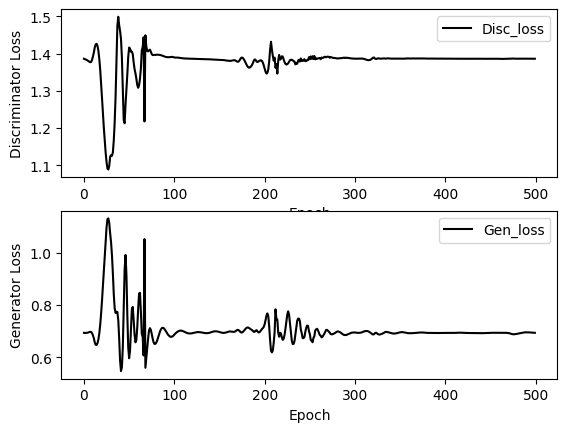

In [100]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [101]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  6.001375888790667


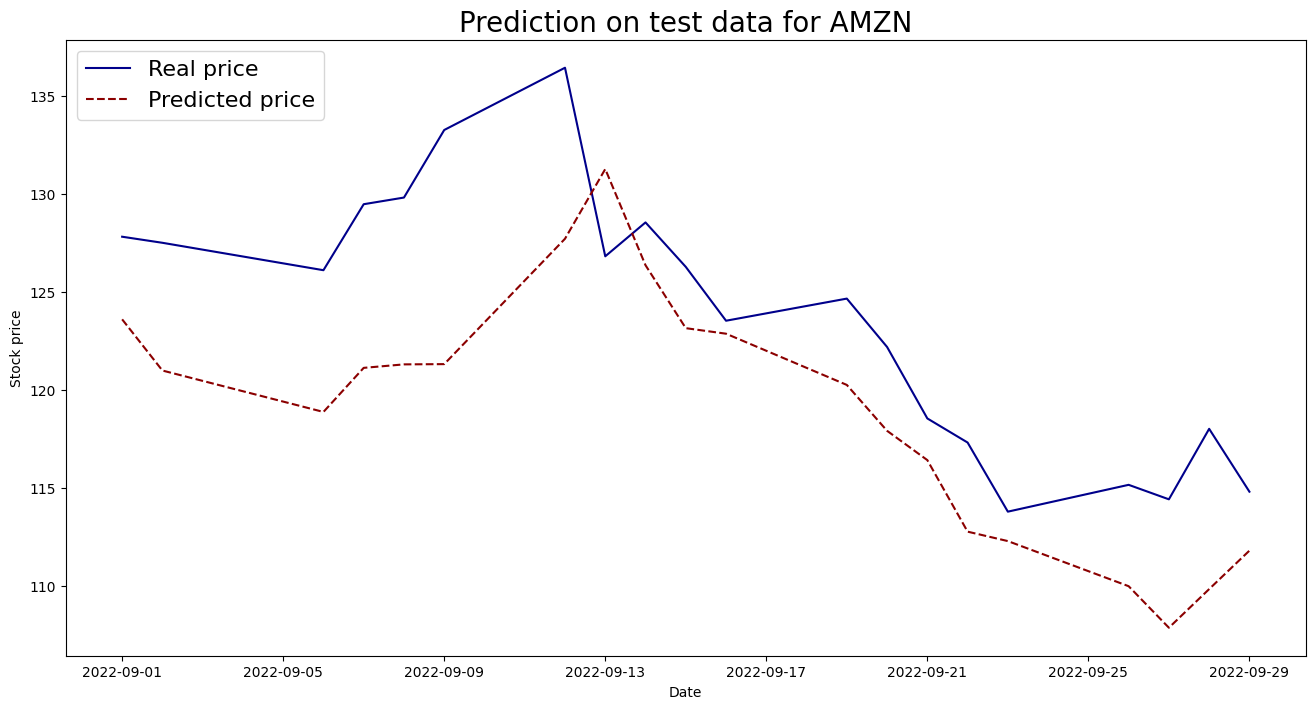

In [102]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)